## CS166 Traffic Simulation Assignment 
Qiqi Xu

Minerva Schools at KGI

**CoCal notebook link**: https://cocalc.com/share/e55bb11e-78cc-478b-9719-751f2ed1bf43/CS166%20Traffic%20Simulation%20Assignment.ipynb?viewer=share

#### Part 1 Traffic jams on a circular road

Implement the single lane, variable speed traffic model described in this paper: Nagel, K., Schreckenberg, M. (1992). A cellular automaton model for freeway traffic. Journal de Physique I, 2(12), 2221–2229.

- Write well-structured and well-documented Python code to implement the model described in the paper.
- Visualize the state of this model over time, to show how traffic jams can appear when traffic density is high enough.
- Analyze how the overall average traffic flow rate varies with traffic density and present your results in your report.

In [239]:
import numpy as np
import scipy as sp
import random 

# (road length, traffic density, maximum velocity, probability of slowing down)
class TrafficSimulation:
    
    def __init__(self, road_length = 100, density = 0.2, max_velocity = 5, slow_prob = 0.3):
        self.road_length = road_length
        self.density = density
        self.max_velocity = max_velocity
        self.slow_prob = slow_prob
        self.flow_count = 0 #set up a counter of how many cars exit and enter the road from the left side at each update
        
        
        self.state = -sp.ones(100, dtype=int)
        for i in range(100):
            if random.random() <= self.density:
                self.state[i] = random.randint(0,5)
        
        
    def update(self):
        m = self.max_velocity
        next_state = -sp.ones(100, dtype=int)
        
        
        #find all the cars' indice
        current_index = np.argwhere(self.state!=-1)
        num_cars = len(current_index)
    
        for i in range(num_cars):
        #the index of interest now and the next one
            c = current_index[i]
            n = current_index[(i+1) % len(current_index)]
            v = self.state[c]
            
            #calculate the distance between two cars
            dist = (n-c)%100 
             
            #accelearation
            if v < m and dist >= v+1:
                v = v + 1
                 
            #slowing down
            if v > 0 and dist <= v :
                v = dist - 1
                 
            #randomization            
            if v > 0 and random.random() <= self.slow_prob:
                v = v - 1
            
            #update the speed after movement 
            next_state[(c + v) % 100] = v
            
            if c+v >= 100:
                self.flow_count += 1
            
        self.state = next_state
        #print(''.join('.' if x == -1 else str(x) for x in self.state))

        
    def display(self):
        print(''.join('.' if x == -1 else str(x) for x in self.state))
  
        

In [240]:
random.seed(100)

Test1 = TrafficSimulation(density = 0.3)

t = 30 #time step
for i in range(t):
    Test1.update()
    Test1.display()

..2....0...3.0..2...30.1...1.1....3.....3..........4...1.1.1..2...0.1...3......1000.1.....00..2..0.1
.2..2...1...1.1...2.0.1.1...1..2......4....3..........3.10..1....3.1.1......4..000.1.1....0.1...20..
...2...3.1...1..2..1.10..1....2..2.......3....3.......0.0.1..1....1.1.1.......200.10...2...1..2.0.1.
.....2..1..2..1...2.10.1..1.....2...3........4...3....0..1..2.1....10...2.....00.100.....2...2.1.1.1
1......2..2..2..2.0.0.1.1...2.....2....3........3...3..1...2.1..2..0.1....2...00.00.1.......3.1.1.1.
..2.....1..1...2.1.10..1.1.....3.....3....3........3..2.1...1..2..20..1.....2.00.00...2......10.0.0.
.....3...1...2.0..100...1..2.......4.....4....4.....1..1.1....2..20.1...2....100.0.1.....3...0.10..1
.2......3..2..1.1.00.1....2..2..........5...3.....4..1.0...2....20.1.1.....3.00.1.1..2......3.10.1..
....3.....2..2.1.10.1.1.....2...3..........3....4...20..1.....3.0.1.1.1.....10.1.1.1....3....100..1.
2.......4...2.1.10.1.1..2......3....4..........4..2.0.1...2....1.1.1.1..2...00..1.1..2.....

In [226]:
random.seed(100)
#calculate the flow rate

flow_rate = []
densities = []
time_step = 200

for i in range(1,20): #loop through the densities
    p = 0.05*i
    densities.append(p) #density
    p_all_flow_rates = [] #store the flow rates of each simulation for one density
   
    for j in range(20): #repeat simulation each density for 20 times
        T = TrafficSimulation(density = p) #simulation
        for i in range(time_step): #time step = 200
            T.update()
        p_all_flow_rates.append(T.flow_count/float(time_step))
    
    #average flow rate for one density
    p_flow_rate = sum(p_all_flow_rates)/20.0
    flow_rate.append(p_flow_rate)

Text(0,0.5,u'Flow rate')

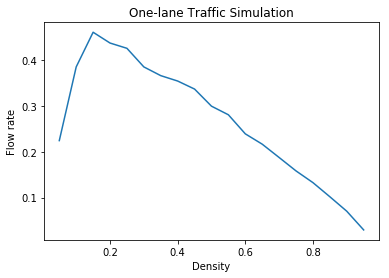

In [241]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(densities,flow_rate)
plt.title("One-lane Traffic Simulation")
plt.xlabel("Density")
plt.ylabel("Flow rate")

### Part 2: Multi-lane highways

Implement the 2-lane, symmetric, uni-directional, variable speed model in this paper: Rickert, M., et al. (1996). Two Lane Traffic Simulations using Cellular Automata. Physica A: Statistical Mechanics and its Applications, 231(4), 534–550.


- A description, in your report, of how this model works. What are the assumptions, parameters, and update rules of the model? Do not just copy and paste from the paper. Explain the cellular automaton in your own words and as clearly as possible.

- Write well-structured and well-documented Python code to implement the model described in the paper.

- Visualize the state of this model over time, to show the typical traffic patterns that can emerge. Your results will again depend on traffic density.

- Analyze how much more traffic can flow through a multi-lane road, compare to a single lane road, at the same traffic density. Present your results in your report.



In [1]:
import numpy as np
import scipy as sp
import random 

'''
    Inputs of the class: 
    road length, traffic density, maximum velocity, 
    the probability of slowing down, the probability of changing lanes
'''
class TrafficSimulation_2lane:
    
    def __init__(self, road_length = 100, density = 0.2, max_velocity = 5, slow_prob = 0.3, lane_prob = 0.8):
        self.road_length = road_length
        self.density = density
        self.max_velocity = max_velocity
        self.slow_prob = slow_prob
        self.lane_prob = lane_prob
        self.flow_count = 0
        
        #Set up 2 empty lanes
        self.state1 = -sp.ones(100, dtype=int)
        self.state2 = -sp.ones(100, dtype=int)
    
        #Populate cars on the lanes according to initial probabilities
        for i in range(200):
            if random.random() <= self.density:
                if i<100:
                    self.state1[i] = random.randint(0,5)
                else:
                    self.state2[i-100] = random.randint(0,5)
        
    def update(self): 
        m = self.max_velocity
        
        next_state1 = -sp.ones(100, dtype=int)
        next_state2 = -sp.ones(100, dtype=int)

        #find all the cars' indice
        current_index1 = np.argwhere(self.state1!=-1)
        current_index2 = np.argwhere(self.state2!=-1)
        update_index1 = current_index1
        update_index2 = current_index2
                
        
        '''Determine if cars on lane #1 will change lanes '''
        for i in range(len(current_index1)):
            c = current_index1[i] #current cell index
            n1 = current_index1[(i+1) % len(current_index1)] #next cell index
            v = self.state1[c]
            
            #Symmetric model: a car only changes lanes when there's someone in front of it where gap < speed
            #Note that the gap equals distance - 
            if (n1-c)%100-1 >= v + 1: 
                break #doesn't change lanes
                
            #check if there's a car at the same index next lane, 
            if self.state2[c] >= 0 or (n1-c)%100 > v:
                break #doesn't change lanes

            #look back on the other lane
            for dx in range(1, m): 
                if self.state2[(c - dx)%100] >= 0: #there is a car behind on the other lane             
                    loback = False
                else: 
                    loback = True

            #find the car ahead in the other lane
            for dx in range(1, m):
                if self.state2[(c + dx)%100] >= 0: 
                    lo = dx - 1 #the neighborhood ahead has a car
                    break
                else:
                    lo = m - 1 #the neighborhood ahead is empty

            #change lanes
            if loback == True and lo >= v and random.random()<= self.lane_prob:
                
                #find the current cell index in the list of car indices
                c_index = np.argwhere(update_index1 == c)
                #delete the index from car indices the original lane  
                new_index1 = np.delete(update_index1, c_index)
                #because numpy array is immutable
                update_index1 = new_index1

                #add the index to the destination lane
                update_index2 = update_index2.flatten()
                #find the correct index to add to the sorted list of car indices
                insertindex = np.searchsorted(update_index2, c[0])
                #insert the index in the correct order
                update_index2 = np.insert(update_index2, insertindex, c)


        '''Determine if cars on lane 2 will change lanes '''
        for i in range(len(current_index2)):
            c = current_index2[i] #current cell index
            n2 = current_index2[(i+1) % len(current_index2)] #next cell index
            v = self.state2[c]
            
            #check the space ahead on the same lane
            if (n2-c)%100 >= v + 1:
                break
            
            #check the cell next to it on the next lane
            if self.state1[c] >= 0:
                break
            
            #look back on the other lane
            for dx in range(1, m): 
                if self.state1[(c - dx)%100] >= 0: #there is a car behind on the other lane             
                    loback = False
                else: 
                    loback = True
                    
            #look ahead on the other lane
            for dx in range(1, m):
                if self.state1[(c + dx)%100] >= 0: 
                    lo = dx - 1
                    break
                else:
                    lo = m - 1
            
            #change lanes
            if loback == True and lo >= v and random.random()<= self.lane_prob:
                
                #find the current cell index in the list of car indices
                c_index = np.argwhere(update_index2 == c)
                #delete the index from car indices the original lane
                new_index2 = np.delete(update_index2, c_index)
                #because numpy array is immutable
                update_index2 = new_index2
                
                #add the index to the destination lane
                update_index1 = update_index1.flatten()
                #find the correct index to add to the sorted list of car indices
                insertindex = np.searchsorted(update_index1, c[0])
                #insert the index in the correct order
                update_index1 = np.insert(update_index1, insertindex, c)
                
    
        
        '''update the car movements on both lane'''
        ###LANE 1###
        for i in range(len(update_index1)):
        #the index of interest now and the next one
            c = update_index1[i]
            n = update_index1[(i+1) % len(update_index1)]
            v = self.state1[c]
            
            #accelearation
            if v < m and (n-c)%100 > v:
                v = v + 1
                 
            #slowing down
            if v > 0 and (n-c)%100 <= v :
                v = (n-c)%100 -1
                 
            #randomization            
            if v > 0 and random.random() <= self.slow_prob:
                v = v-1
            
            #update speed and movement 
            next_state1[(c + v) % 100] = v
            
            if c + v >= 100:
                self.flow_count += 1 #update flow count
         
        ###LANE 2###
        for i in range(len(update_index2)):
        #the index of interest now and the next one
            c = update_index2[i]
            n = update_index2[(i+1) % len(update_index2)]
            v = self.state2[c]
            #print c,n,v 
            
            #accelearation
            if v < m and (n-c)%100 > v:
                v = v + 1
                 
            #slowing down
            if v > 0 and (n-c)%100 <= v :
                v = (n-c)%100 - 1
                 
            #randomization            
            if v > 0 and random.random() <= self.slow_prob:
                v = v - 1
             
            #update speed and movement 
            next_state2[(c + v) % 100] = v
        
            if c + v >= 100:
                self.flow_count += 1 #update flow count
       
        #update the states of both lane
        self.state1 = next_state1
        self.state2 = next_state2

        
    def display(self):
        print(''.join('.' if x == -1 else str(x) for x in self.state1)),"____",
        print(''.join('.' if x == -1 else str(x) for x in self.state2))
        print



In [2]:
random.seed(100)

#set up the simulation 
T2 = TrafficSimulation_2lane(density = 0.15)
#time steps
t=50

for i in range(t):
    T2.update()
    T2.display()

...3...0....4..............1............3.........................40........0.................10..1. ____ .4.......2................1............20.....5.......0..1.......10.1.1.....5..1....4...1.0.1..1....

2.....3.1.......4............2.............3......................0.1........1................00.... ____ ......5....2................2..........0.1.........5..0...1......00.0..1......2..2....2.0.0...2.1...

...3..0...2.........4...........3..............4...................1..2........2..............00.... ____ ..........4..2.................3........1..2.........2.1...1.....0.1.1...2.....1....3..1.1.1...1..2.

......0......3..........4..........3...............4................1....3........3...........0.1... ____ .3.0.......1....3..................4......2...3.......1..2...2....1.1..2....3....2....2.10...2...2..

.0.....1........3............5.........4................5.............2.....3.........4........1..2. ____ 3..0.........2......4..................4....2.....4.....2...3.

Text(0,0.5,u'Flow rate')

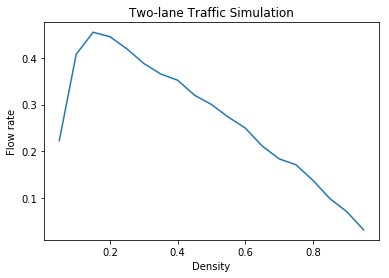

In [247]:
random.seed(100)
#calculate the flow rate for the two-lane model

flow_rate_2 = []
densities = []
time_step = 200

for i in range(1,20): #loop through the densities
    p = 0.05*i
    densities.append(p) #density
    p_all_flow_rates = [] #store the flow rates of each simulation for one density
   
    for j in range(20): #repeat simulation each density for 20 times
        T2 = TrafficSimulation_2lane(density = p) #simulation
        for i in range(time_step): #time step = 200
            T2.update()
        p_all_flow_rates.append(T2.flow_count/float(time_step))
    
    #average flow rate for one density
    flow_rate_2.append(sum(p_all_flow_rates)/20.0/2.0)

%matplotlib inline

plt.plot(densities,flow_rate_2)
plt.title("Two-lane Traffic Simulation")
plt.xlabel("Density")
plt.ylabel("Flow rate")
                                
                                

For the one-lane model, the max flow rate is: 0.45525 and it's reached at the density of: 0.04 .
For the two-lane model, the max flow rate is: 0.46025 and it's reached at the density of: 0.04 .


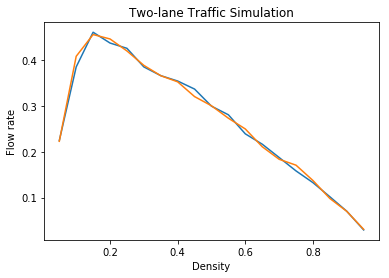

In [248]:
%matplotlib inline

plt.plot(densities,flow_rate)
plt.plot(densities,flow_rate_2)

#plt.scatter(densities,flow_rate)
#plt.scatter(densities,flow_rate_2)

plt.title("Two-lane Traffic Simulation")
plt.xlabel("Density")
plt.ylabel("Flow rate")

print "For the one-lane model, the max flow rate is:", max(flow_rate_2),
print "and it's reached at the density of:",0.02*flow_rate_2.index(max(flow_rate_2)),"."

print "For the two-lane model, the max flow rate is:", max(flow_rate),
print "and it's reached at the density of:",0.02*flow_rate.index(max(flow_rate)),"."
